In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def loadData(code1="KO", code2="PEP", start="2023-01-01", end="2024-01-01"):

    data = yf.download([code2, code1], start, end)["Close"]
    spread = data[code2] - data[code1]

    return data, spread, code1, code2

def signals(data, spread, code1, code2):
    spread_mew = spread.rolling(window=20).mean()
    spread_sigma = spread.rolling(window=20).std()

    data["Mew"] = spread_mew
    data["Sigma"] = spread_sigma
    data["Spread"] = spread

    data["Signal"] = 0
    data.loc[spread > spread_mew + 2 * spread_sigma, "Signal"] = 1   # short a long b
    data.loc[spread < spread_mew - 2 * spread_sigma, "Signal"] = -1  # long a short b

    # trending 2days in a row, not just once
    confirmed = (
        (data["Signal"] == data["Signal"].shift(1)) &
        (data["Signal"] != 0)
    )
    data["ConfirmedSignal"] = data["Signal"].where(confirmed, 0)

    return data, code1, code2

In [2]:

def backtest(data, code1, code2, transactionFee=0.001):
    cash = 10000
    a_stocks = 0
    b_stocks = 0

    for date, row in data.iterrows():
        if pd.isna(row["Mew"]) or pd.isna(row["Spread"]):
            continue

        spread = row["Spread"]
        signal = row["ConfirmedSignal"]
        a_price = row[code1]
        b_price = row[code2]

        if signal == 1:
            aValue = a_stocks * a_price # sell a buy b
            cash += aValue * (1 - transactionFee)
            a_stocks = 0
            b_stocks += cash / b_price
            cash -= cash * transactionFee
            cash = 0

        elif signal == -1: # sell b buy a
            bValue = b_stocks * b_price
            cash += bValue * (1 - transactionFee)
            b_stocks = 0
            a_stocks += cash / a_price
            cash -= cash * transactionFee
            cash = 0

        value = a_stocks * a_price + b_stocks * b_price + cash
        data.loc[date, "Portfolio"] = value

    print(f"Started at 10000, ended at {value:.2f}")
    return data, code1, code2


In [3]:
def graph(data, code1, code2):
    plt.figure(figsize=(10, 5))

    # plot 1
    plt.subplot(2, 1, 1)
    data[code1].plot(title="KO vs PEP Prices", ax=plt.gca())
    data[code2].plot(ax=plt.gca(), label='PEP')
    spread= data["Spread"]
    spread.plot(ax=plt.gca(), label='Spread', color='green')
    plt.legend([code1, code2, 'Spread'])

    # Plot 2
    plt.subplot(2, 1, 2)
    portfolio = data["Portfolio"]
    portfolio.plot(title="Portfolio Value", ax=plt.gca())
    plt.legend(['Portfolio'])

    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1-50226680.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download([code2, code1], start, end)["Close"]
[*********************100%***********************]  2 of 2 completed


Started at 10000, ended at 9803.19


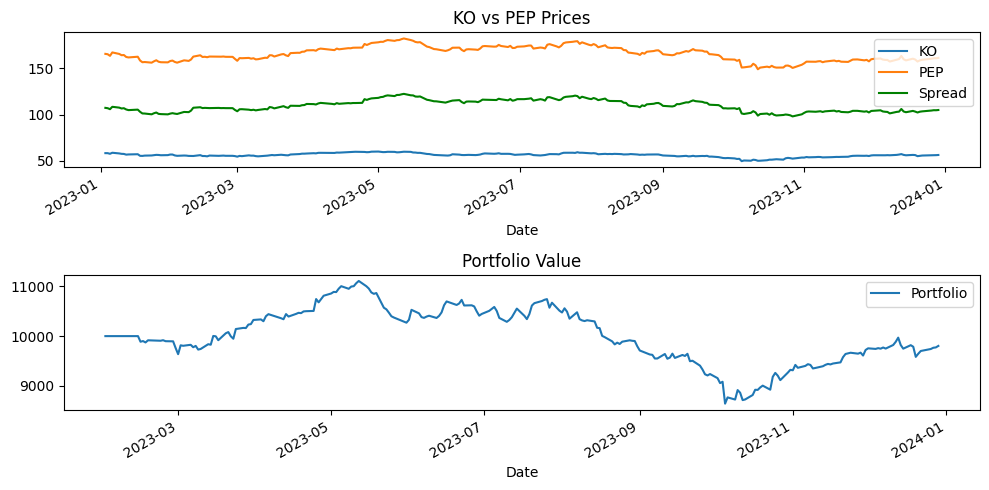

In [4]:
data, spread, code1, code2 = loadData()
data, code1, code2 = signals(data, spread, code1, code2)
data, code1, code2 = backtest(data, code1, code2)
graph(data, code1, code2)